In [2]:
import pandas as pd
import numpy as np

# Preprocesamiento de los datos

In [2]:
########################################################################################    BBDD CHINA
X_train = pd.read_pickle("./Datasets/China/X_train_China_Augmented.pkl")
X_val = pd.read_pickle("./Datasets/China/X_val_China.pkl")
X_test = pd.read_pickle("./Datasets/China/X_test_China.pkl")

y_train = pd.read_pickle("./Datasets/China/y_train_China_Augmented.pkl")
y_val = pd.read_pickle("./Datasets/China/y_val_China.pkl")
y_test = pd.read_pickle("./Datasets/China/y_test_China.pkl")

fs = 1000

In [3]:
########################################################################################    BBDD COLOMBIA
X_train = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/X_train_Augmented_PCA.pkl"))
X_val = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/X_val.pkl"))
X_test = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/X_test.pkl"))

y_train = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/y_train_Augmented_PCA.pkl"))
y_val = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/y_val.pkl"))
y_test = pd.DataFrame(pd.read_pickle("./Datasets/Colombia/y_test.pkl"))

fs = 100

In [4]:
############################################################################################# Suavizado y normalización solo para BBDD China
def moving_average(signal, window_size=5):  #Windows Size = 50 para BBDD China y 5 para BBDD Colombia
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')
    
# Convertir cada fila del DataFrame en un arreglo de NumPy y aplicar el suavizado
X_train = np.array([moving_average(ppg_signal.values) for _, ppg_signal in X_train.iterrows()]) #Comentar si X_train_China_Augmented ya que está filtrado en el proceso de Data Augmentation
X_val = np.array([moving_average(ppg_signal.values) for _, ppg_signal in X_val.iterrows()])
X_test = np.array([moving_average(ppg_signal.values) for _, ppg_signal in X_test.iterrows()])

# Normalización Min-Max
def normalize_min_max(signals):
    # Calcular mínimos y máximos por fila
    min_vals = np.min(signals, axis=1, keepdims=True)
    max_vals = np.max(signals, axis=1, keepdims=True)
    # Normalizar cada fila
    return (signals - min_vals) / (max_vals - min_vals)

X_train = normalize_min_max(X_train)
X_val = normalize_min_max(X_val)
X_test = normalize_min_max(X_test)

In [5]:
import numpy as np
import pandas as pd
import pywt

def wavelet_df(
    df: pd.DataFrame, 
    wavelet='db4', 
    level=6
):
    """
    Aplica wavelet a cada fila de un DataFrame.
    
    Parámetros
    ----------
    df       : DataFrame de forma (n_señales, n_muestras). 
               Cada fila es una señal 1D.
    wavelet  : str. Nombre de la wavelet (ej. 'db4', 'sym4', etc.).
    level    : int. Nivel de descomposición wavelet.
               
    Retorna
    -------
    cA_array   : np.array de forma (n_señales, n_muestras). 
                 Aproximación reconstruida para cada señal.
    cD6_array  : np.array de forma (n_señales, n_muestras). 
                 Aproximación reconstruida para cada señal.
    """
    
    n_señales = df.shape[0]
    n_muestras = df.shape[1]
    
    # Para guardar resultados
    cA_array = np.zeros((n_señales, n_muestras))
    cD_array = np.zeros((n_señales, n_muestras))
    
    for i in range(n_señales):
        # 1) Extraer la señal (fila i) como array 1D
        signal = df.iloc[i].values  # (n_muestras,)
        
        # 2) Descomposición wavelet -> cA
        coeffs = pywt.wavedec(signal, wavelet=wavelet, level=level)
        cA = coeffs[0]  # Aproximación en el nivel 'level'
        cD_level = coeffs[1]
        
        # 3) Reconstruir cA al tamaño original
        cA_rec = pywt.upcoef(
            part='a',
            coeffs=cA,
            wavelet=wavelet,
            level=level,
            take=n_muestras
        )

        dA6_rec = pywt.upcoef(
            part='d',
            coeffs=cD_level,
            wavelet=wavelet,
            level=level,
            take=n_muestras
        )        
        # 6) Guardar resultados
        cA_array[i, :] = cA_rec
        cD_array[i, :] = dA6_rec 
    
    return cA_array, cD_array

import matplotlib.pyplot as plt

def plot_wavelet_emd(signal, cA_rec, cD_rec, level=5):
    """
    Grafica la señal original, la aproximación cA{level} y las IMFs obtenidas por EMD.
    """
    num_plots = 3  # señal + cA + cada IMF
    
    fig, axes = plt.subplots(num_plots, 1, figsize=(15, 2 * num_plots), sharex=True)
    #fig.suptitle(f"Wavelet (nivel={level}) + EMD en cA")

    # 1) Señal original
    axes[0].plot(signal, 'b')
    axes[0].set_title("Señal original")
    
    # 2) Aproximación cA{level}
    axes[1].plot(cA_rec, 'g')
    axes[1].set_title(f"Aproximación Wavelet cA{level} (reconstruida)")
    
    axes[2].plot(cD_rec, 'r')
    axes[2].set_title(f"Detalle Wavelet cD{level} (reconstruida)")

    plt.tight_layout()
    plt.show()

In [6]:
#level = 6  # Nivel de detalle para BBDD China
level = 3 # Nivel de detalle para BBDD Colombia
cA_array_train, cD_array_train = wavelet_df(
    pd.DataFrame(X_train), 
    wavelet='db4', 
    level=level
)

cA_array_val, cD_array_val = wavelet_df(
    pd.DataFrame(X_val), 
    wavelet='db4', 
    level=level
)

cA_array_test, cD_array_test = wavelet_df(
    pd.DataFrame(X_test), 
    wavelet='db4', 
    level=level
)

print("cA_array_train.shape:", cA_array_train.shape) 
print("cD_array_train.shape:", cD_array_train.shape)

cA_array_train.shape: (2170, 196)
cD_array_train.shape: (2170, 196)


In [9]:
######################################### Ejecutar solo con BBDD China
from scipy.signal import decimate
#Hacemos Downsampling por explosión del gradiente en mi ordenador

def downsampling(array, q=2):
    array_downsampled = np.array([decimate(signal, q=q, axis=0) for signal in array])
    return array_downsampled

q=6
X_train = downsampling(X_train, q)
X_val = downsampling(X_val, q) 
X_test = downsampling(X_test, q)

cD_array_train = downsampling(cD_array_train, q)
cD_array_val = downsampling(cD_array_val, q)
cD_array_test = downsampling(cD_array_test, q)

In [7]:
X_train = np.expand_dims(X_train, axis=-1)
X_val = np.expand_dims(X_val, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

y_train = y_train.astype(int).values.ravel()
y_val = y_val.astype(int).values.ravel()
y_test = y_test.astype(int).values.ravel()

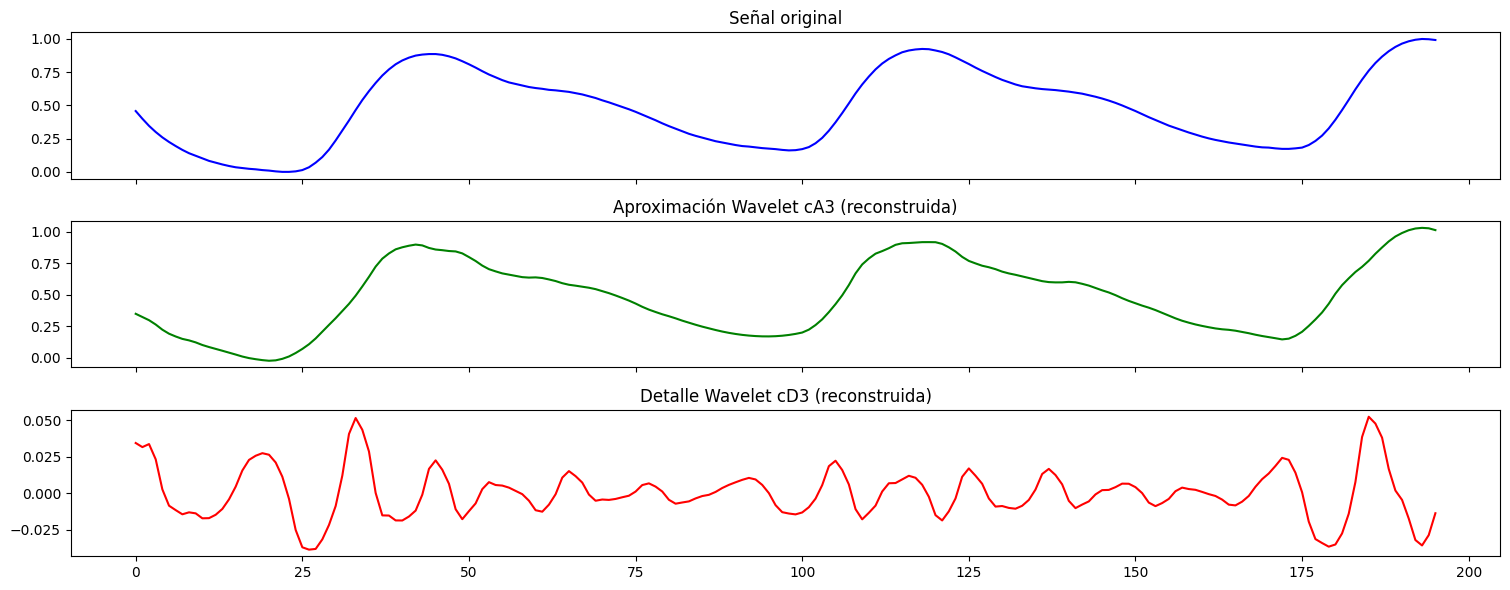

In [8]:
index = 0
plot_wavelet_emd(X_train[index,:], cA_array_train[index], cD_array_train[index], level=level)

# CNN-ResNet-BiLSTM

In [9]:
from keras.callbacks import TensorBoard

import os

# Crear carpeta para guardar los logs de TensorBoard
log_dir = os.path.join("logs", "modelo_cnn_resnet_bilstm")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Verificar la carpeta creada
print(f"Logs de TensorBoard se guardarán en: {log_dir}")

Logs de TensorBoard se guardarán en: logs\modelo_cnn_resnet_bilstm


In [10]:
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Activation, Dropout, Add,
    AveragePooling1D, Bidirectional, LSTM, Dense, Concatenate, Flatten
)
from tensorflow.keras.models import Model

def create_resnet_bilstm_with_wavelet_fixed(input_shape_ppg, wavelet_length):
    """
    Modelo CNN-ResNet-BiLSTM con entrada para wavelets.

    Args:
    - input_shape_ppg: Tuple con la forma de las señales PPG (n_timesteps, n_features).
    - wavelet_length: Longitud de los coeficientes wavelet.

    Returns:
    - model: Modelo compilado listo para entrenar.
    """
    # 🔹 Entrada de PPG
    ppg_input = Input(shape=input_shape_ppg, name='PPG_Input')

    # Primera capa convolucional
    x = Conv1D(64, kernel_size=15, padding="same")(ppg_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Bloques ResNet
    def residual_block(x, filters):
        shortcut = Conv1D(filters, kernel_size=1, padding='same')(x)

        x = Conv1D(filters, kernel_size=7, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Dropout(0.2)(x)

        x = Conv1D(filters, kernel_size=7, padding='same')(x)
        x = BatchNormalization()(x)

        x = Add()([x, shortcut])
        x = Activation('relu')(x)

        # Cambiamos a AvgPooling
        x = AveragePooling1D(pool_size=2)(x)
        return x

    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128)
    x = residual_block(x, 128)

    # BiLSTM
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3))(x)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3))(x)

    # 🔹 Aplanar la salida PPG
    x = Flatten()(x)

    # 🔹 Entrada de Wavelet
    wavelet_input = Input(shape=(wavelet_length,), name="Wavelet_Input")
    y = Dense(128, activation='relu', name="Wavelet_Dense_1")(wavelet_input)
    y = Dropout(0.3, name="Wavelet_Dropout_1")(y)
    y = Dense(64, activation='relu', name="Wavelet_Dense_2")(y)
    y = Dropout(0.3, name="Wavelet_Dropout_2")(y)

    # 🔹 Combinación de ambas entradas
    combined = Concatenate(name="PPG_Wavelet_Concatenation")([x, y])

    # 🔹 Capas densas finales
    z = Dense(64, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01), name="Dense_1")(combined)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = Dropout(0.4)(z)

    z = Dense(32, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.01), name="Dense_2")(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = Dropout(0.3)(z)

    # Capa de salida
    output = Dense(1, activation='sigmoid', name="Output")(z)

    # Construcción del modelo
    model = Model(inputs=[ppg_input, wavelet_input], outputs=output)
    return model


In [11]:
from tensorflow.keras.optimizers import AdamW, Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2

def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        pt = tf.exp(-bce)
        focal_loss = alpha * (1 - pt) ** gamma * bce
        return focal_loss
    return loss

input_shape_ppg = (X_train.shape[1], X_train.shape[2]) 
wavelet_length = cD_array_train.shape[1]

model = create_resnet_bilstm_with_wavelet_fixed(input_shape_ppg, wavelet_length)

optimizer = AdamW(learning_rate=1e-4)
#optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)  

# 🔹 Compilar modelo con focal loss para desbalanceo
model.compile(optimizer=optimizer, loss=focal_loss(), metrics=['accuracy', AUC()])

# 🔹 Calcular pesos de clases para entrenamiento balanceado
classes = np.array([0, 1])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = {0: class_weights[0], 1: class_weights[1]}

# 🔹 Callbacks para optimización
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
checkpoint = ModelCheckpoint("./Modelos/modelo_cnn_resnet_bilstm/best_model.keras", monitor='val_loss', save_best_only=True)

model.save('./Modelos/modelo_cnn_resnet_bilstm/modelo_cnn_resnet_bilstm.keras')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ PPG_Input (InputLayer)        │ (None, 196, 1)            │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d (Conv1D)               │ (None, 196, 64)           │           1,024 │ PPG_Input[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 196, 64)           │             256 │ conv1d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation (Activation)       │ (None, 196, 64)           │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_2 (Conv1D)             │ (None, 196, 64)           │          28,736 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 196, 64)           │             256 │ conv1d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_1 (Activation)     │ (None, 196, 64)           │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 196, 64)           │               0 │ activation_1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_3 (Conv1D)             │ (None, 196, 64)           │          28,736 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 196, 64)           │             256 │ conv1d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_1 (Conv1D)             │ (None, 196, 64)           │           4,160 │ activation[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 196, 64)           │               0 │ batch_normalization_2[0][… │
│                               │                           │                 │ conv1d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_2 (Activation)     │ (None, 196, 64)           │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ average_pooling1d             │ (None, 98, 64)            │               0 │ activation_2[0][0]         │
│ (AveragePooling1D)            │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_5 (Conv1D)             │ (None, 98, 64)            │          28,73

 Total params: 1,030,209 (3.93 MB)

 Trainable params: 1,028,353 (3.92 MB)

 Non-trainable params: 1,856 (7.25 KB)

In [12]:
# 🔹 Entrenamiento con optimización mejorada
history = model.fit([X_train, cD_array_train], y_train, 
                    epochs=50, batch_size=32,
                    validation_data=([X_val, cD_array_val], y_val),
                    class_weight=class_weights, 
                    callbacks=[tensorboard_callback, reduce_lr, checkpoint])

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 20s 93ms/step - accuracy: 0.5152 - auc: 0.5181 - loss: 1.4160 - val_accuracy: 0.6250 - val_auc: 0.5077 - val_loss: 1.3019 - learning_rate: 1.0000e-04
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.5137 - auc: 0.5108 - loss: 1.3030 - val_accuracy: 0.6250 - val_auc: 0.5105 - val_loss: 1.1984 - learning_rate: 1.0000e-04
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.5428 - auc: 0.5586 - loss: 1.1949 - val_accuracy: 0.3750 - val_auc: 0.5531 - val_loss: 1.1044 - learning_rate: 1.0000e-04
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.5537 - auc: 0.5914 - loss: 1.0980 - val_accuracy: 0.3750 - val_auc: 0.5824 - val_loss: 1.0177 - learning_rate: 1.0000e-04
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.5340 - auc: 0.5554 - loss: 1.0144 - val_accuracy: 0.3750 - val_auc: 0.5153 - val_loss: 0.9402 - learning_rate: 1.0000e-04
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0

# RESULTADOS ENTRENAMIENTO

In [13]:
test_loss, test_accuracy, test_auc = model.evaluate([X_val, cD_array_val], y_val)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6046 - auc: 0.3191 - loss: 0.3281    
Test Loss: 0.3604
Test Accuracy: 0.5192
Test AUC: 0.5361


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step


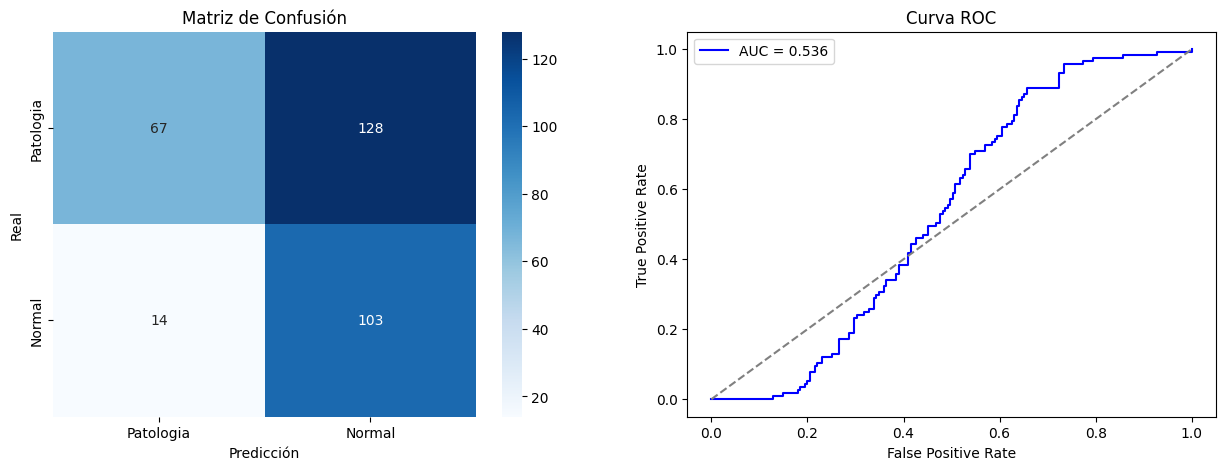


Umbral óptimo: 0.03834645450115204

Reporte de Clasificación:
               precision    recall  f1-score   support

   Patologia       0.83      0.34      0.49       195
      Normal       0.45      0.88      0.59       117

    accuracy                           0.54       312
   macro avg       0.64      0.61      0.54       312
weighted avg       0.68      0.54      0.53       312



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs_val = model.predict([X_val, cD_array_val])  # Devuelve las probabilidades para cada clase


# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_val, y_pred_probs_val)
roc_auc = auc(fpr, tpr)
# Calcular la diferencia entre TPR y FPR
optimal_idx = np.argmax(tpr - fpr)  # Índice del umbral óptimo
optimal_threshold = thresholds[optimal_idx]  # Umbral óptimo


threshold = optimal_threshold  # Umbral de decisión
y_pred = (y_pred_probs_val > threshold).astype(int)  # 1 para "Normal", 0 para "Anormal"
#y_pred = (y_pred_probs_test > 0.5).astype(int)  # Convierte a 0 o 1

# Calcular la matriz de confusión
cm = confusion_matrix(y_val, y_pred)



# Graficar la matriz de confusión
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Patologia", "Normal"], yticklabels=["Patologia", "Normal"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")


# Graficar la curva ROC
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

print(f"\nUmbral óptimo: {optimal_threshold}\n" )

# Reporte de clasificación
print("Reporte de Clasificación:\n", classification_report(y_val, y_pred, target_names=['Patologia', 'Normal']))



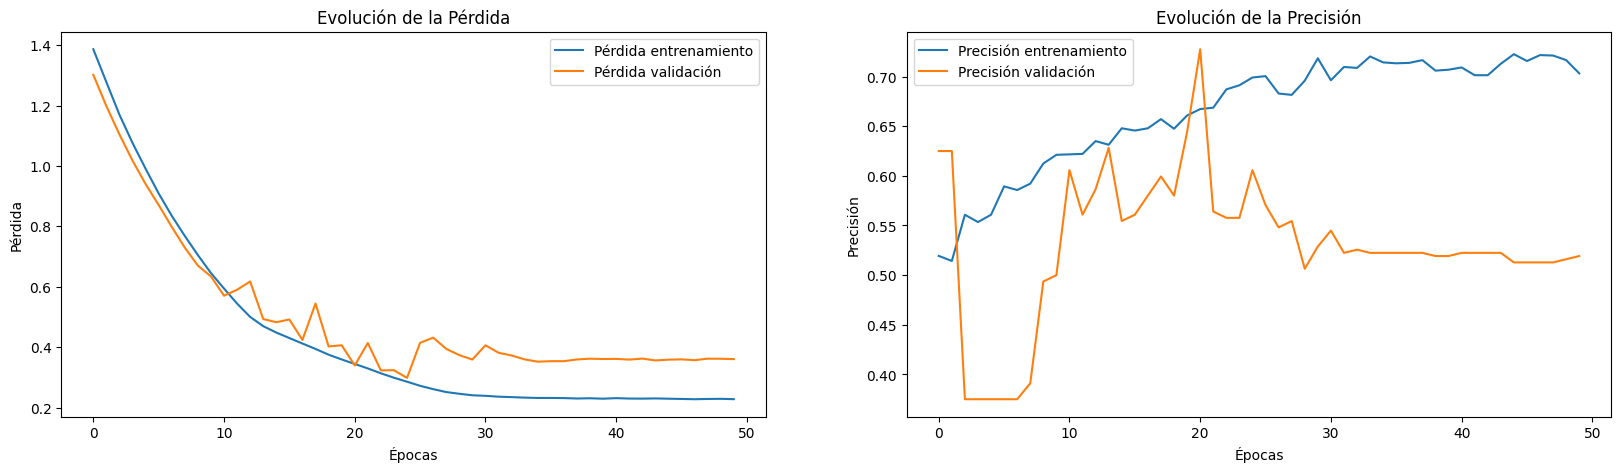

In [15]:
plt.figure(figsize=(20, 5))

# Gráfica de la pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.title("Evolución de la Pérdida")

# Gráfica de la precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title("Evolución de la Precisión")

plt.show()

# RESULTADOS FUERA DE MUESTRA

In [16]:
test_loss, test_accuracy, test_auc = model.evaluate([X_test, cD_array_test], y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test AUC: {test_auc:.4f}")

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6824 - auc: 0.6208 - loss: 0.3312    
Test Loss: 0.3430
Test Accuracy: 0.6359
Test AUC: 0.6921


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


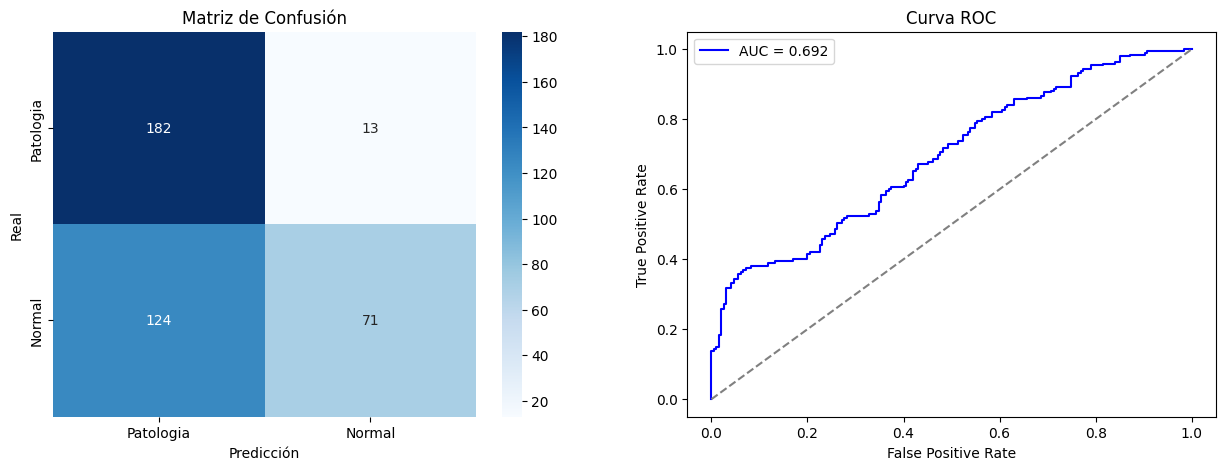


Umbral óptimo: 0.4720973074436188

Reporte de Clasificación:
               precision    recall  f1-score   support

   Patologia       0.59      0.93      0.73       195
      Normal       0.85      0.36      0.51       195

    accuracy                           0.65       390
   macro avg       0.72      0.65      0.62       390
weighted avg       0.72      0.65      0.62       390



In [17]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

y_pred_probs_test = model.predict([X_test, cD_array_test])  # Devuelve las probabilidades para cada clase


# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs_test)
roc_auc = auc(fpr, tpr)
# Calcular la diferencia entre TPR y FPR
optimal_idx = np.argmax(tpr - fpr)  # Índice del umbral óptimo
optimal_threshold = thresholds[optimal_idx]  # Umbral óptimo


threshold = optimal_threshold  # Umbral de decisión
y_pred = (y_pred_probs_test > threshold).astype(int)  # 1 para "Normal", 0 para "Anormal"
#y_pred = (y_pred_probs_test > 0.5).astype(int)  # Convierte a 0 o 1

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)



# Graficar la matriz de confusión
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Patologia", "Normal"], yticklabels=["Patologia", "Normal"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")


# Graficar la curva ROC
plt.subplot(1,2,2)
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Línea de referencia
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.show()

print(f"\nUmbral óptimo: {optimal_threshold}\n" )

# Reporte de clasificación
print("Reporte de Clasificación:\n", classification_report(y_test, y_pred, target_names=['Patologia', 'Normal']))


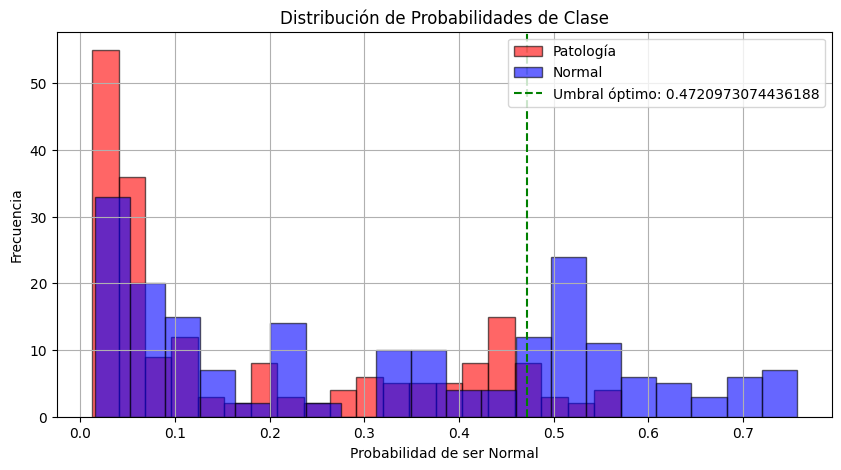

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Separar las probabilidades según la clase
proba_normal = y_pred_probs_test[y_test == 1]  # Probabilidades de la clase "Normal"
proba_patologia = y_pred_probs_test[y_test == 0]  # Probabilidades de la clase "Patologia"

# Crear histogramas
plt.figure(figsize=(10, 5))
plt.hist(proba_patologia, bins=20, alpha=0.6, label="Patología", color='red', edgecolor='black')
plt.hist(proba_normal, bins=20, alpha=0.6, label="Normal", color='blue', edgecolor='black')

# Personalización
plt.axvline(x=optimal_threshold, color='green', linestyle='dashed', label=f"Umbral óptimo: {optimal_threshold}")
plt.xlabel("Probabilidad de ser Normal")
plt.ylabel("Frecuencia")
plt.title("Distribución de Probabilidades de Clase")
plt.legend()
plt.grid(True)
plt.show()


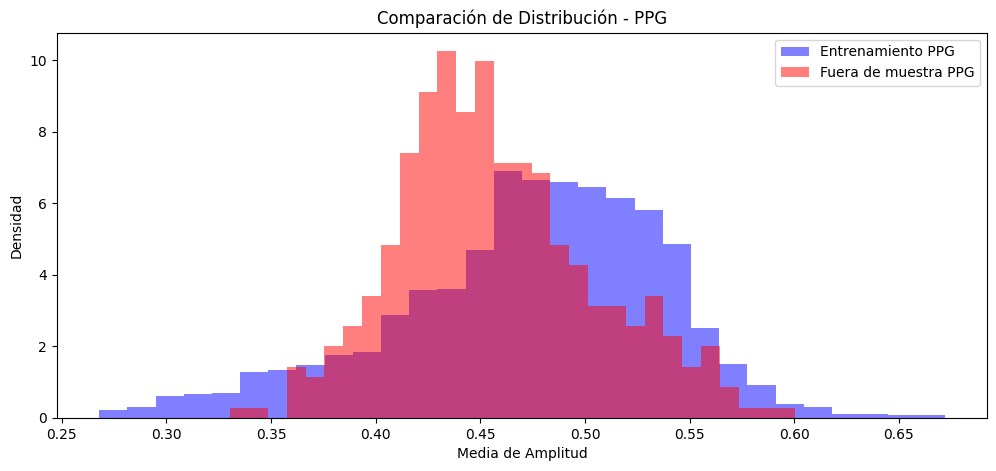

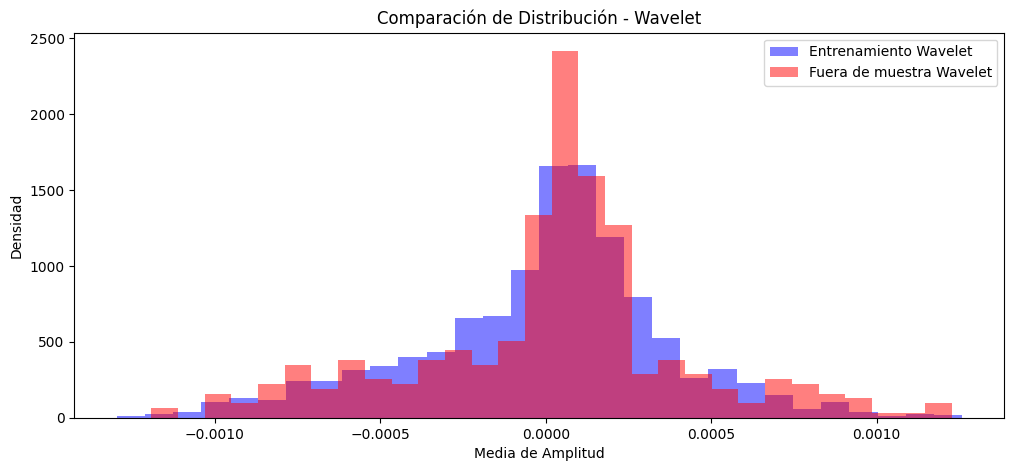

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.hist(np.mean(X_train[:,:,0], axis=1), bins=30, alpha=0.5, label="Entrenamiento PPG", color='blue', density=True)
plt.hist(np.mean(X_test[:,:,0], axis=1), bins=30, alpha=0.5, label="Fuera de muestra PPG", color='red', density=True)
plt.xlabel("Media de Amplitud")
plt.ylabel("Densidad")
plt.legend()
plt.title("Comparación de Distribución - PPG")
plt.show()

plt.figure(figsize=(12, 5))
plt.hist(np.mean(cD_array_train, axis=1), bins=30, alpha=0.5, label="Entrenamiento Wavelet", color='blue', density=True)
plt.hist(np.mean(cD_array_test, axis=1), bins=30, alpha=0.5, label="Fuera de muestra Wavelet", color='red', density=True)
plt.xlabel("Media de Amplitud")
plt.ylabel("Densidad")
plt.legend()
plt.title("Comparación de Distribución - Wavelet")
plt.show()


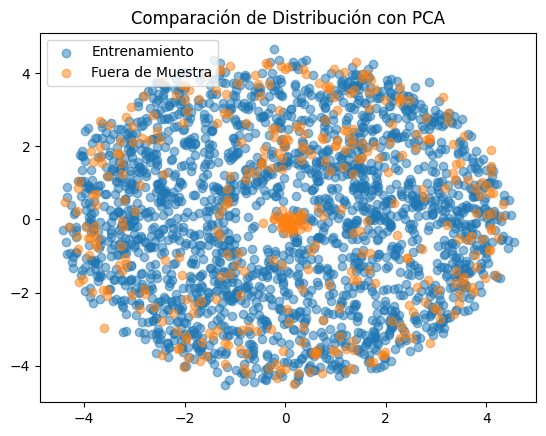

In [20]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train[:,:,0])
X_test_pca = pca.transform(X_test[:,:,0])

plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], label="Entrenamiento", alpha=0.5)
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], label="Fuera de Muestra", alpha=0.5)
plt.legend()
plt.title("Comparación de Distribución con PCA")
plt.show()


# Guardar el modelo

In [ ]:
from tensorflow.keras.utils import plot_model
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("arial.ttf", 32)

plot_model(model, to_file='./Modelos/modelo_cnn_resnet_bilstm/model_plot.png', show_shapes=True, show_layer_names=True)

visualkeras.layered_view(
    model, 
    font=font,
    legend=True, 
    spacing=50,  # Más espacio entre capas
    scale_xy=2,  # Escala horizontal/vertical
    scale_z=1    # Reducir la profundidad 3D para que sea más claro
).save('./Modelos/modelo_cnn_resnet_bilstm/keras_3D.png')

visualkeras.layered_view(
    model, 
    font=font,
    legend=True, 
    spacing=40, 
    draw_volume=False  # Desactiva la vista en 3D
).save('./Modelos/modelo_cnn_resnet_bilstm/keras_2D.png')

